Author: SRISAICHARAN VELISETTI

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2  
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
from scipy.signal import order_filter 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv
import scipy.ndimage.filters as nd_filters
import time

%matplotlib inline

#  Shape Alignment  

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

## Helper Functions

In [7]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

## Code  

apple  image :
Error in alignment: 190.82765391919844
Runtime: 0.3428218364715576  seconds


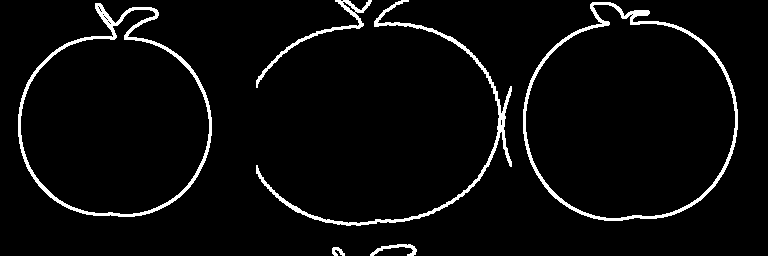



bat  image :
Error in alignment: 422.0975789638798
Runtime: 0.7831614017486572  seconds


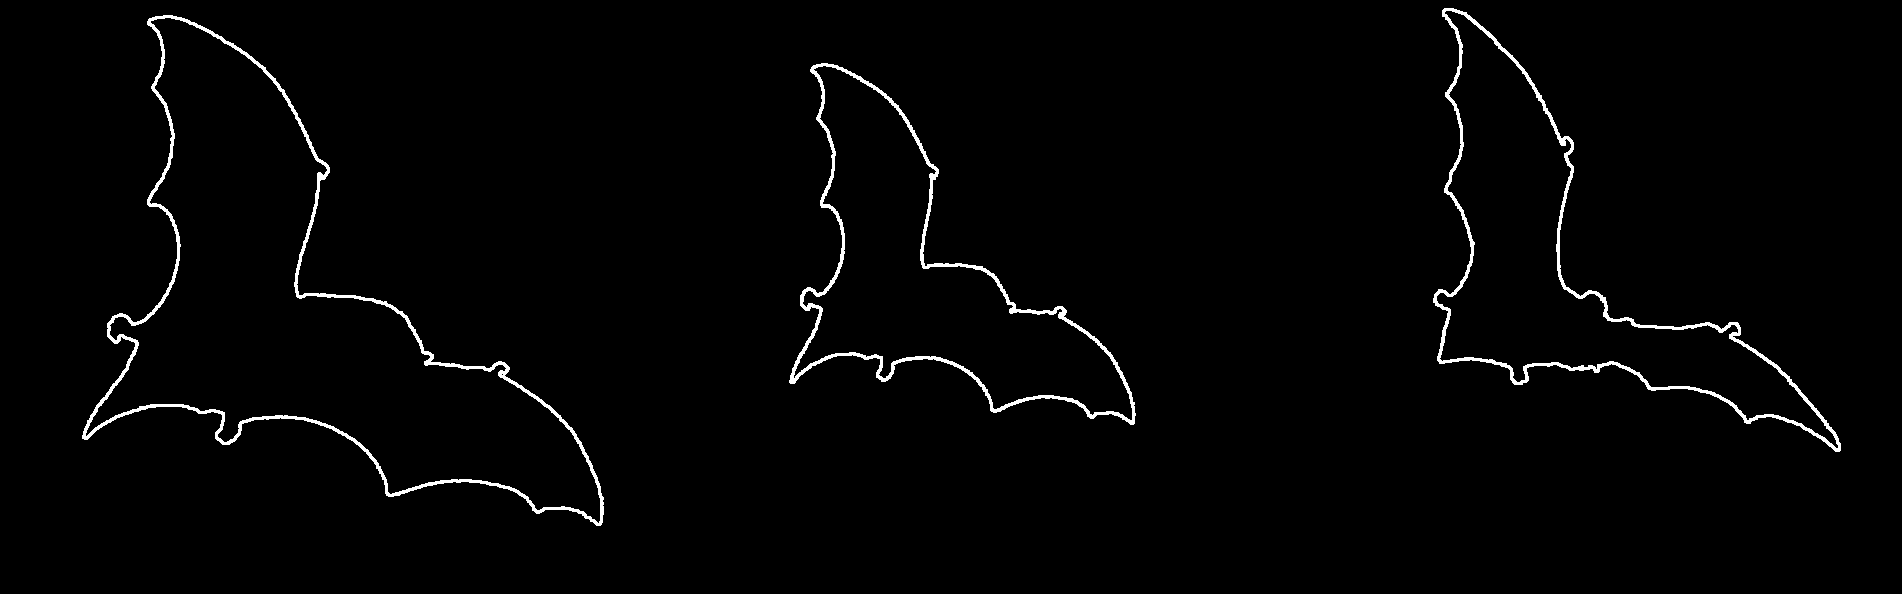



bell  image :
Error in alignment: 182.8544758014561
Runtime: 0.0630791187286377  seconds


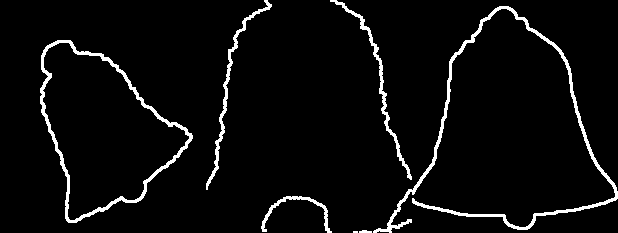



bird  image :
Error in alignment: 245.66670889948062
Runtime: 0.20827293395996094  seconds


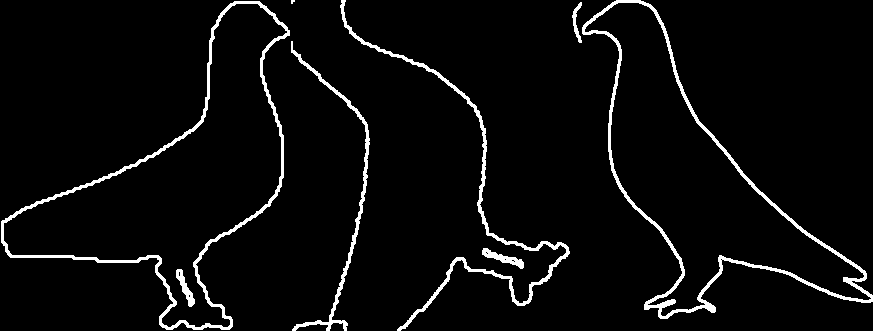



Bone  image :
Error in alignment: 321.06297605188126
Runtime: 0.21085739135742188  seconds


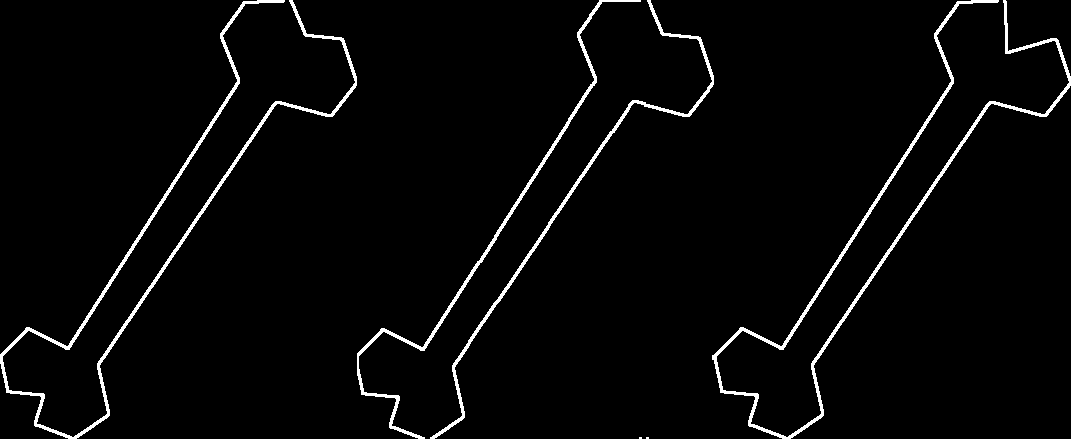



bottle  image :
Error in alignment: 246.58650966276264
Runtime: 0.03693366050720215  seconds


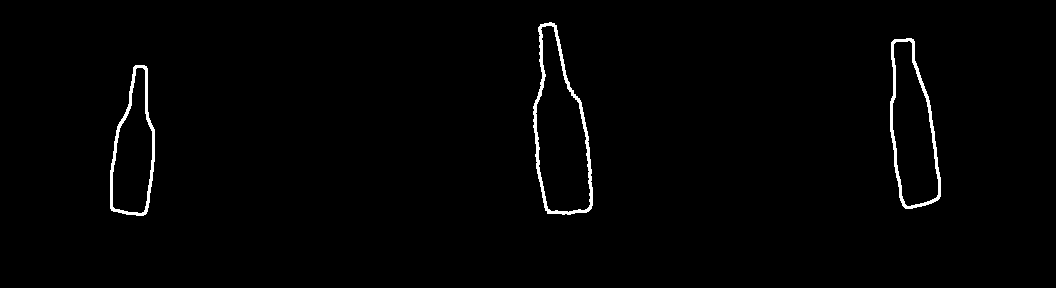



brick  image :
Error in alignment: 304.4194951133843
Runtime: 0.0421905517578125  seconds


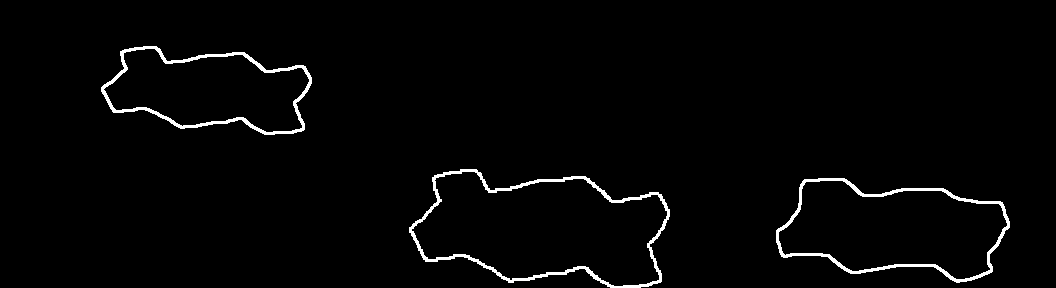



butterfly  image :
Error in alignment: 210.7330877394948
Runtime: 0.27244043350219727  seconds


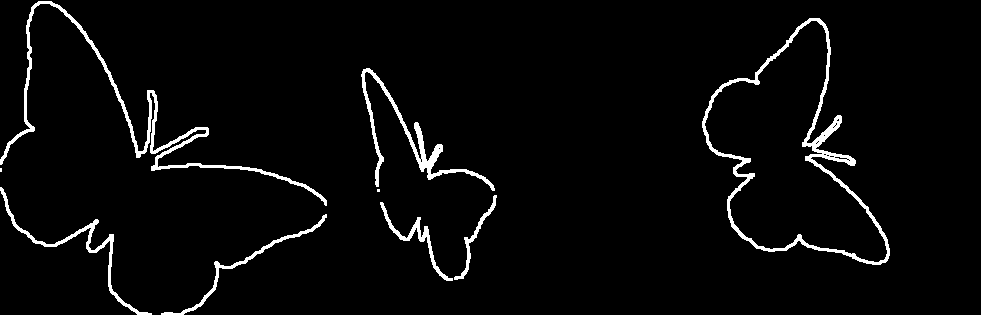



camel  image :
Error in alignment: 273.9955229176538
Runtime: 0.8191878795623779  seconds


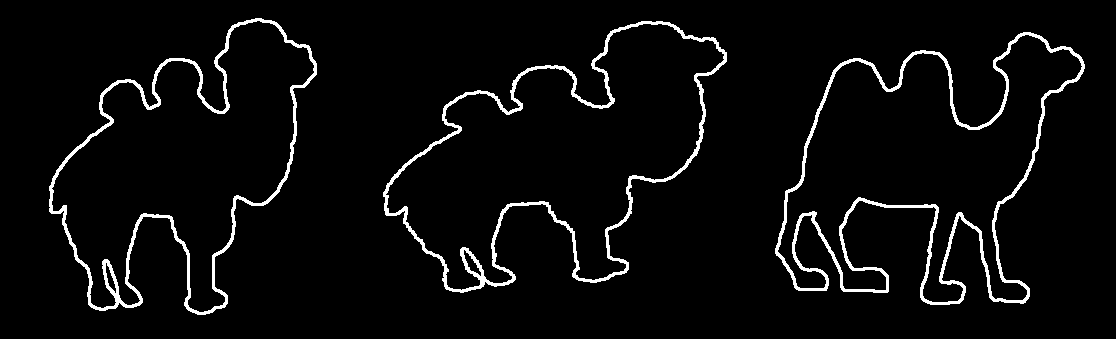



car  image :
Error in alignment: 243.11833170127017
Runtime: 0.04138684272766113  seconds


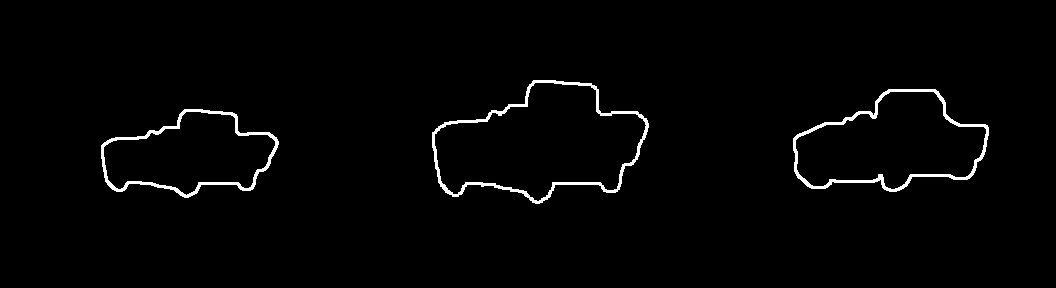



carriage  image :
Error in alignment: 284.04361265051693
Runtime: 0.2817716598510742  seconds


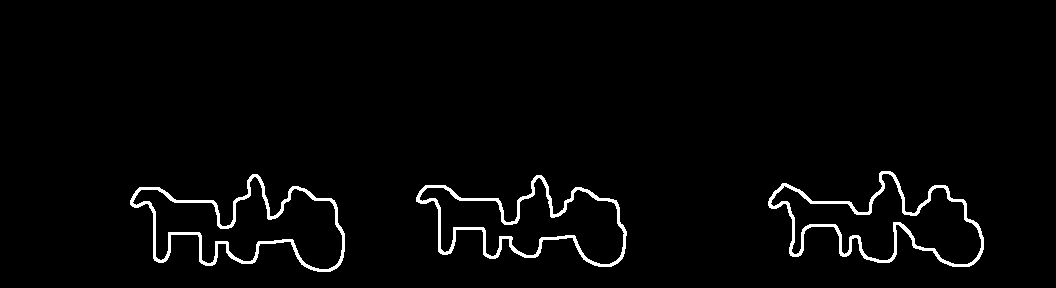



cattle  image :
Error in alignment: 368.57096299092115
Runtime: 1.5196340084075928  seconds


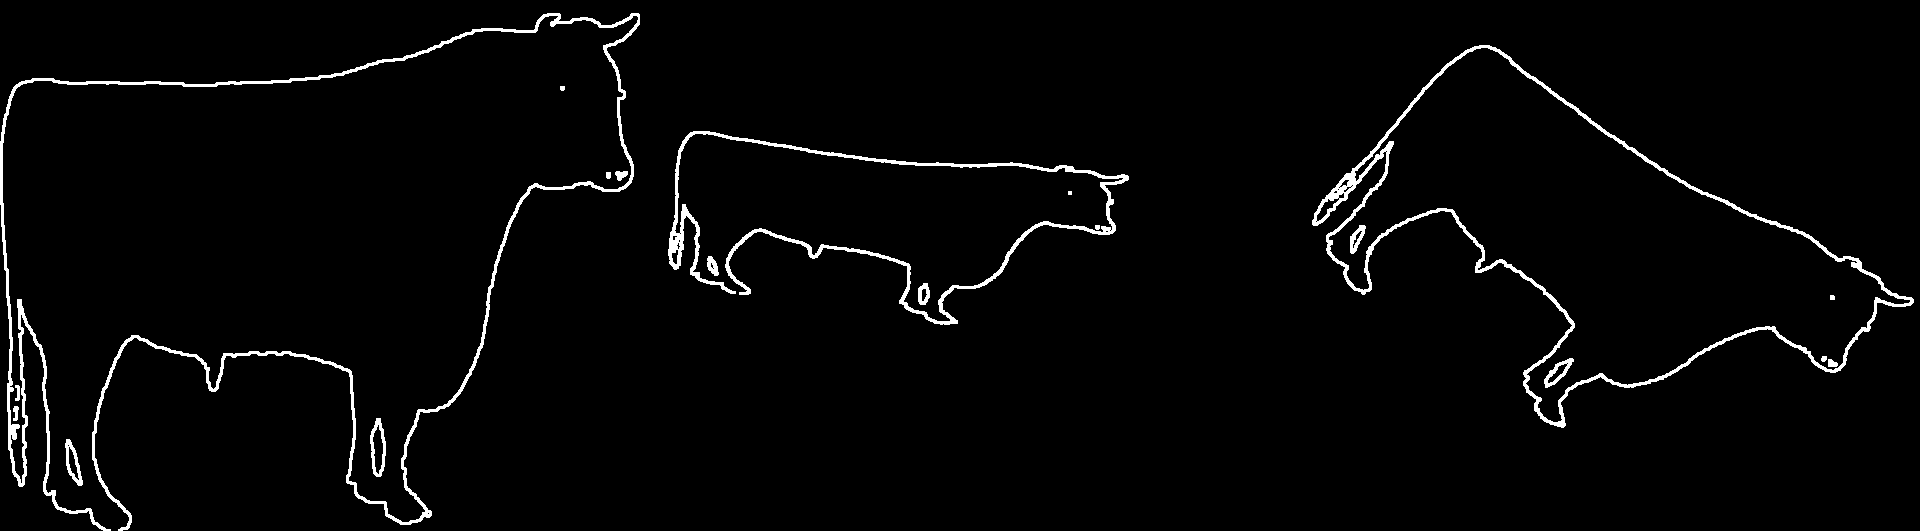



cellular_phone  image :
Error in alignment: 261.9945144530477
Runtime: 0.13954663276672363  seconds


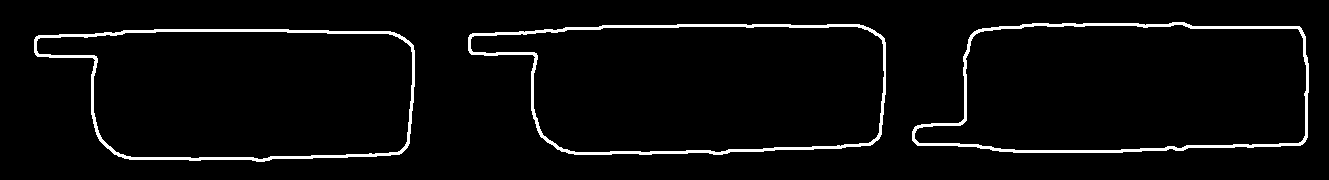



chicken  image :
Error in alignment: 153.9737269041597
Runtime: 0.13274788856506348  seconds


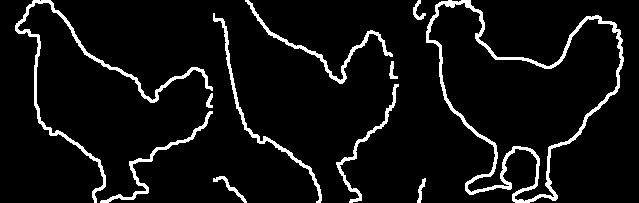



children  image :
Error in alignment: 156.34019593044252
Runtime: 0.015490531921386719  seconds


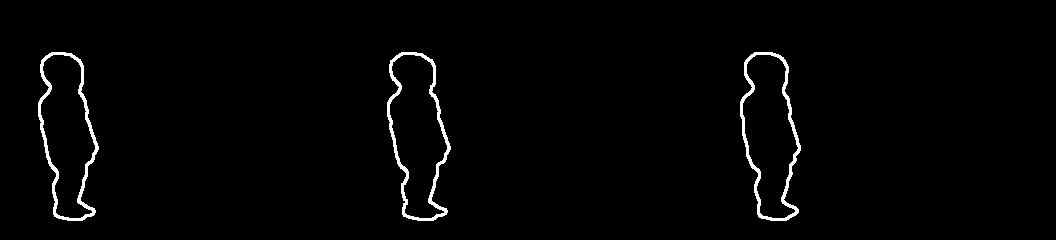



device7  image :
Error in alignment: 383.3379573139192
Runtime: 1.345196008682251  seconds


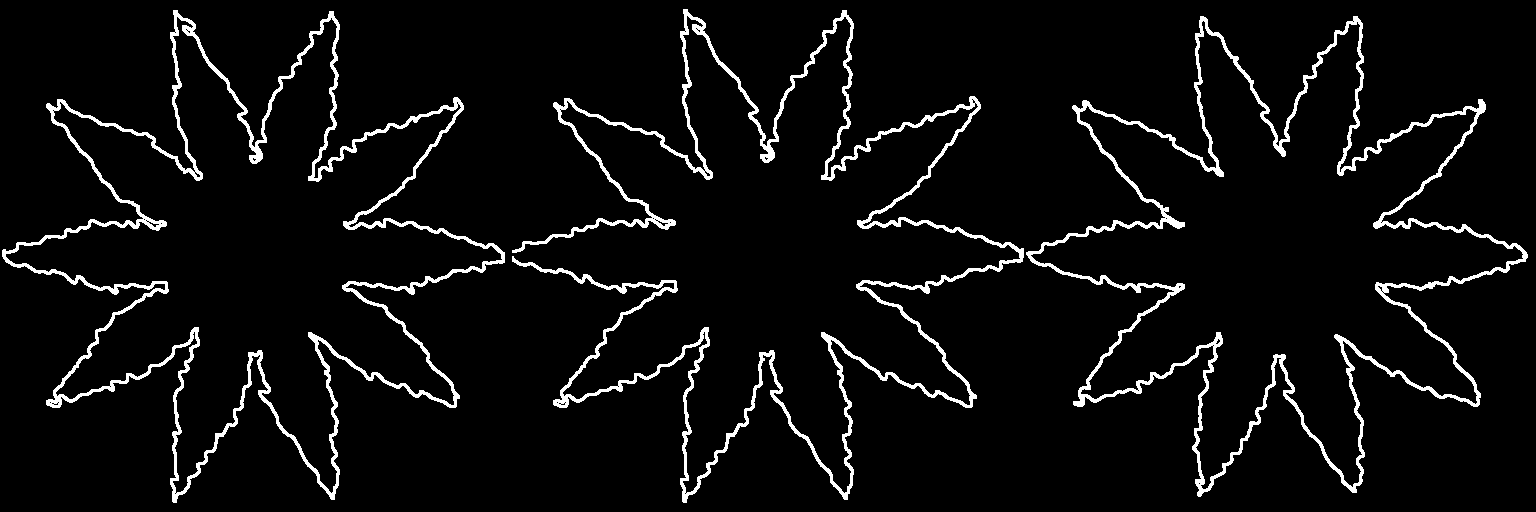



dog  image :
Error in alignment: 357.240285212594
Runtime: 1.676307201385498  seconds


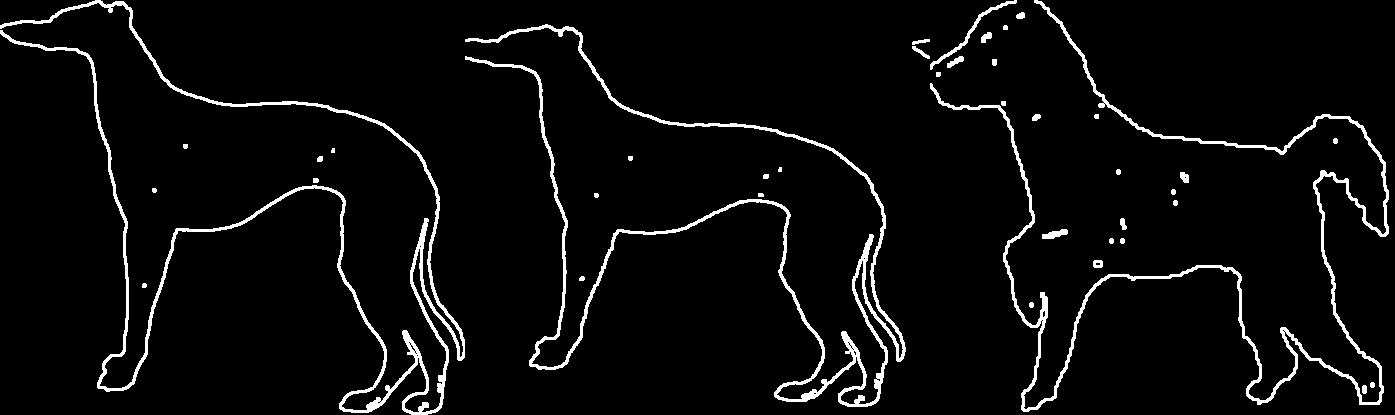



elephant  image :
Error in alignment: 566.157192395939
Runtime: 2.14085054397583  seconds


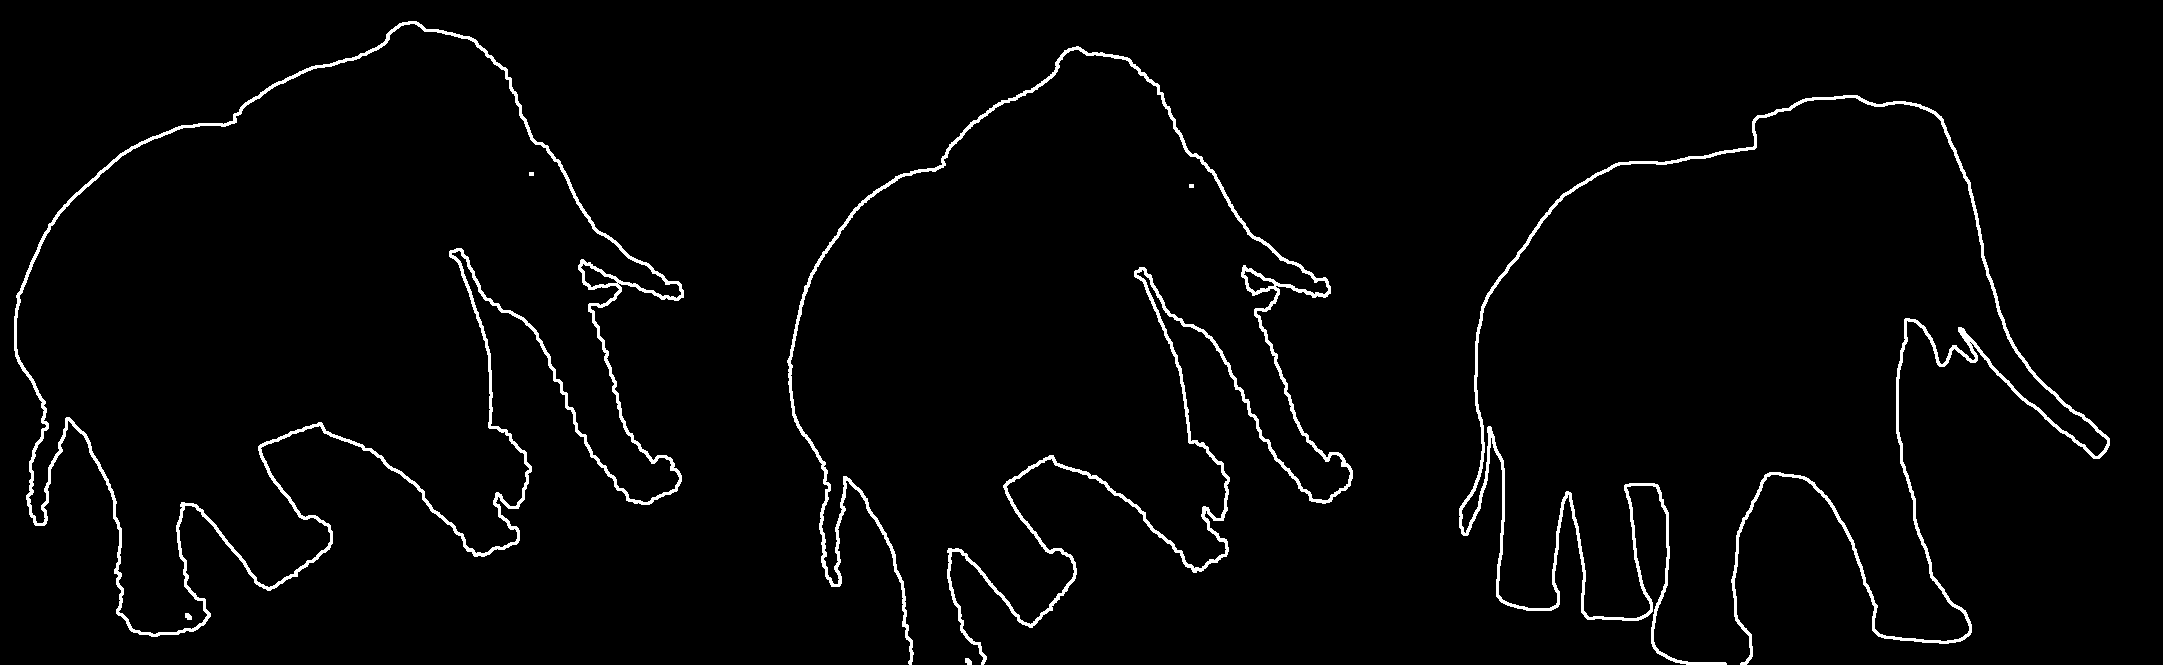



face  image :
Error in alignment: 232.9575544203047
Runtime: 0.10117292404174805  seconds


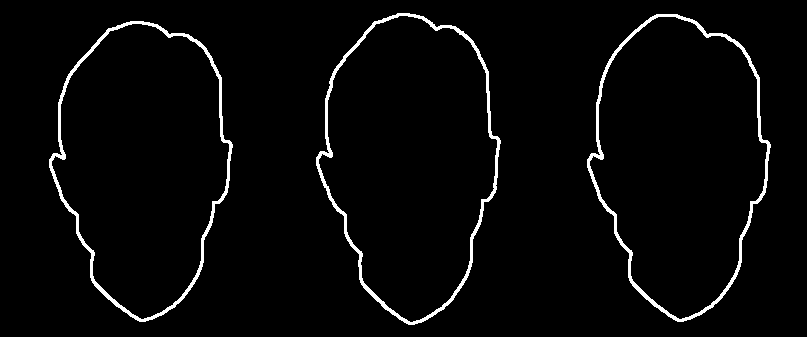



fork  image :
Error in alignment: 357.7992103912451
Runtime: 1.3269805908203125  seconds


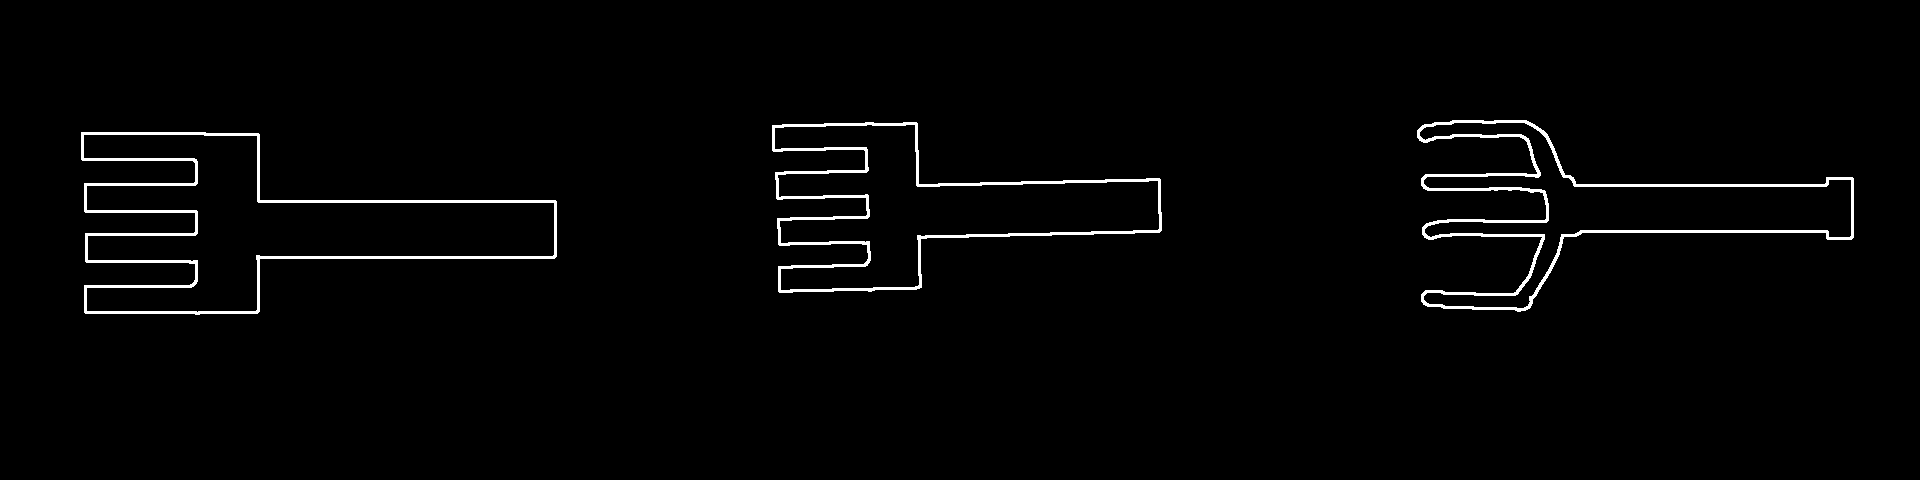



hammer  image :
Error in alignment: 162.8805862697613
Runtime: 0.07893943786621094  seconds


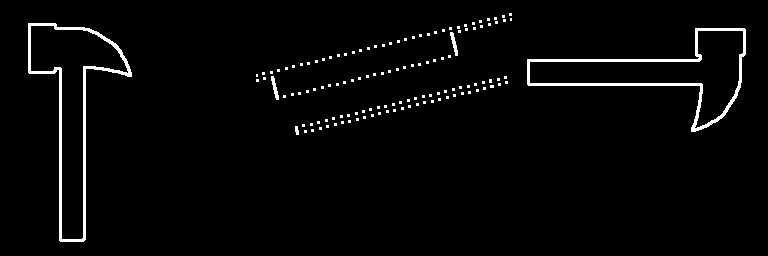



Heart  image :
Error in alignment: 328.2514868488008
Runtime: 0.21845173835754395  seconds


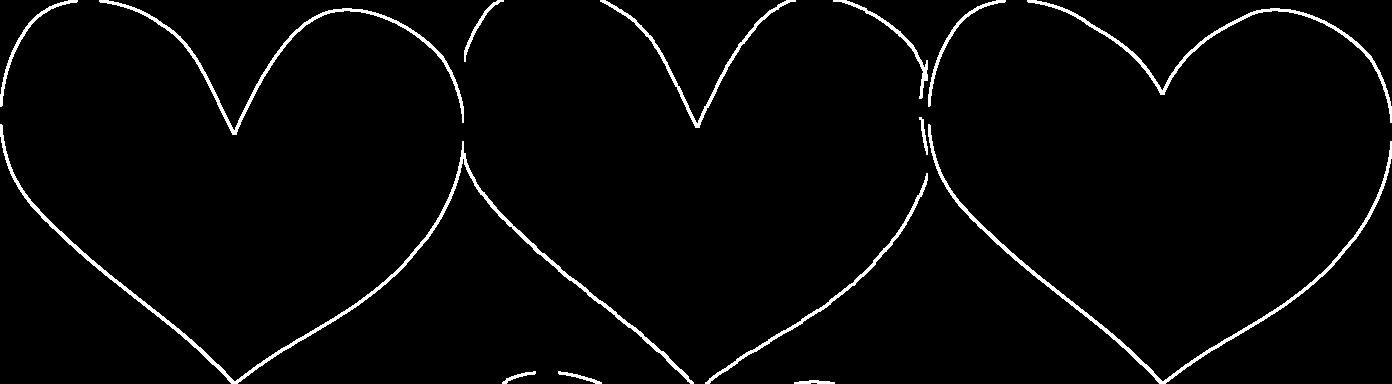



horse  image :
Error in alignment: 495.21621704450286
Runtime: 3.1163437366485596  seconds


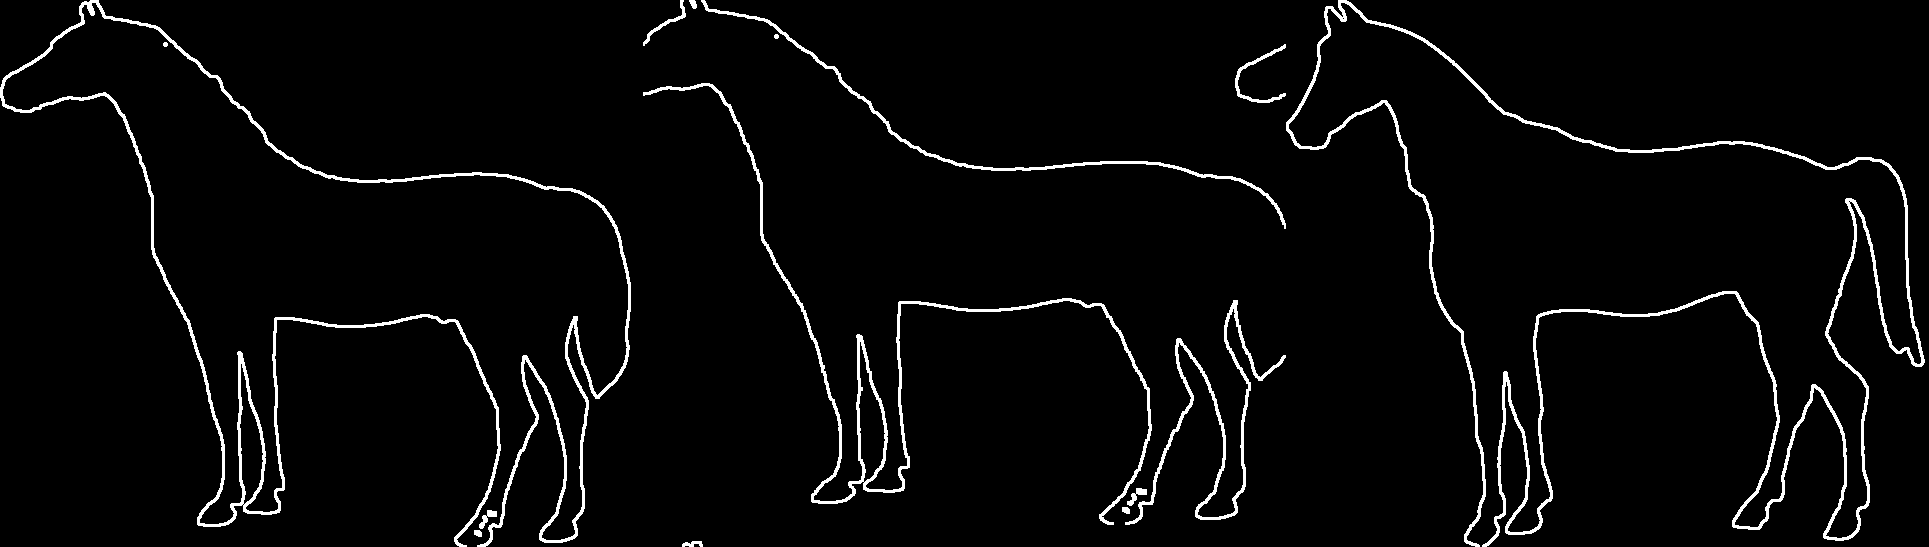



jar  image :
Error in alignment: 384.85488459982787
Runtime: 0.6387035846710205  seconds


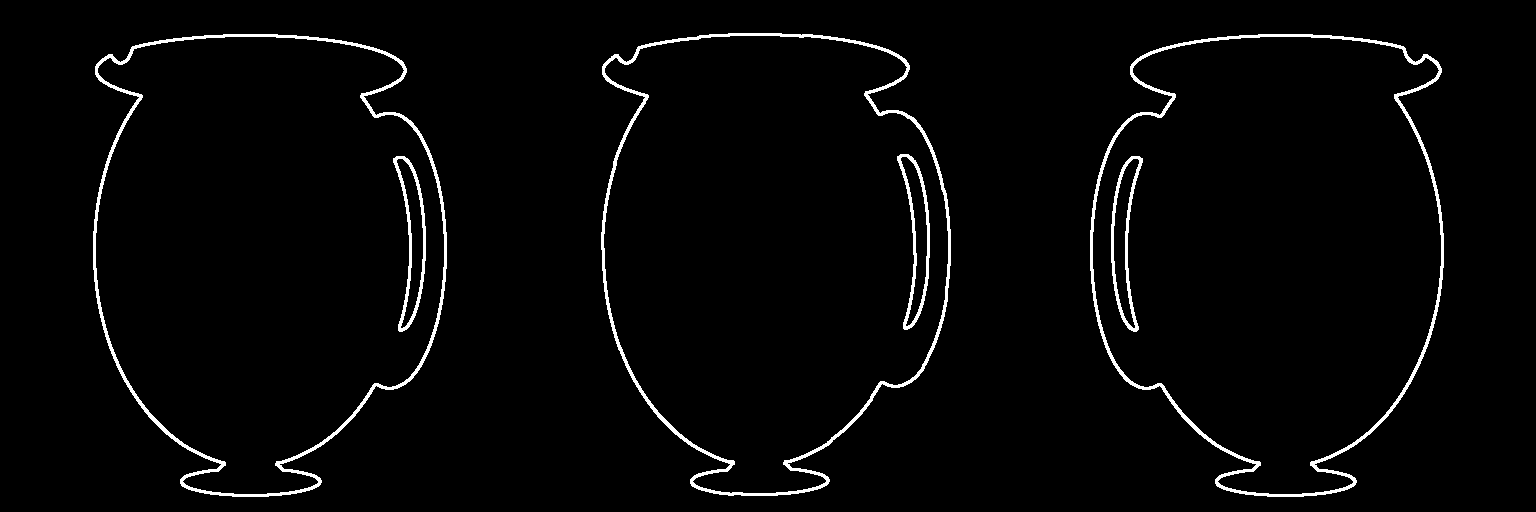



turtle  image :
Error in alignment: 252.73521278079056
Runtime: 0.20398831367492676  seconds


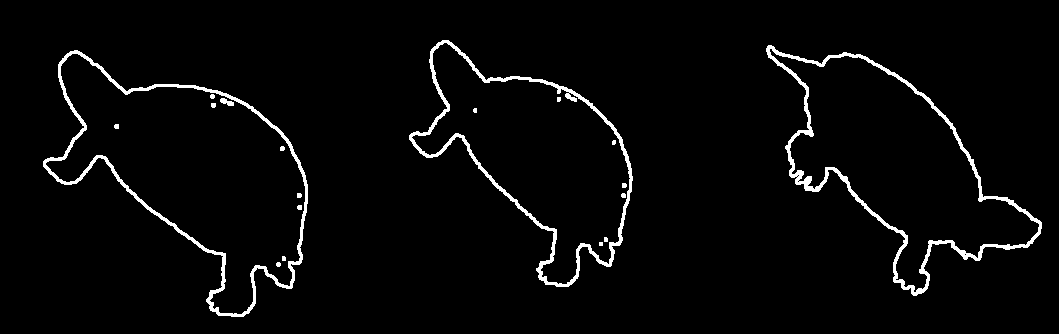

In [8]:
def findTransform(A, B):
    d = A.shape[1]
    A_centroid = np.mean(A, axis=0)
    B_centroid = np.mean(B, axis=0)
    A_shift = A - A_centroid
    B_shift = B - B_centroid
    H_mat = np.dot(A_shift.T, B_shift)
    U, S, Vt = np.linalg.svd(H_mat)
    Rot = np.dot(Vt.T, U.T)
    trans = B_centroid.T - np.dot(Rot, A_centroid.T)
    Transform_mat = np.identity(d + 1)
    Transform_mat[:d, :d] = Rot
    Transform_mat[:d, d] = trans

    return Transform_mat

def nearestNeighbor(X, Y):
    eucd_dist = np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2) ** 0.5
    nn_distance = np.min(eucd_dist, axis=1)
    nn_idx = np.argmin(eucd_dist, axis=1)

    return nn_distance, nn_idx

def ICP(edg_pt1, edg_pt2, T_init, no_iterations, tolerance):
    m = edg_pt1.shape[1]

    edg_pt1_ = np.ones((m + 1, edg_pt1.shape[0]))
    edg_pt2_ = np.ones((m + 1, edg_pt2.shape[0]))
    edg_pt1_[:m, :] = np.copy(edg_pt1.T)
    edg_pt2_[:m, :] = np.copy(edg_pt2.T)
    edg_pt1_ = np.dot(T_init, edg_pt1_)
    init_error = 0

    for i in range(no_iterations):
        nn_distance, nn_idx = nearestNeighbor(edg_pt1_[:m, :].T, edg_pt2_[:m, :].T)
        Transform_mat = findTransform(edg_pt1_[:m, :].T, edg_pt2_[:m, nn_idx].T)
        edg_pt1_ = np.dot(Transform_mat, edg_pt1_)
        mean_error = np.mean(nn_distance)

        if np.abs(init_error - mean_error) < tolerance:
            break
        init_error = mean_error

    Transform_mat = findTransform(edg_pt1, edg_pt1_[:m, :].T)

    return edg_pt1_


imgPath = '/content/part2_images/'

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick',
           'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone',
           'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork',
           'hammer', 'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

for i in range(numObj):
    im1 = cv2.imread(imgPath + objList[i] + '_1.png', 0)
    im2 = cv2.imread(imgPath + objList[i] + '_2.png', 0)

    x1, y1 = np.where(im1 == 255)
    x2, y2 = np.where(im2 == 255)

    transl_x =  np.mean(x1) - np.mean(x2)
    transl_y = np.mean(y1) - np.mean(y2)

    scale_x = np.var(x2) / np.var(x1)
    scale_y = np.var(y2) / np.var(y1)

    T_init = np.array([[scale_x, 0, transl_x],[0, scale_y, transl_y],[0, 0, 1]])

    edg_pt1 = np.array([x1, y1]).T
    edg_pt2 = np.array([x2, y2]).T

    t0 = time.time()
    result_edg_pts = ICP(edg_pt1, edg_pt2, T_init, 50, 0.005)
    runtime = time.time() - t0

    result_img = np.zeros_like(im1)
    for j in range(result_edg_pts.shape[1]):
        x = int(result_edg_pts[:, j][0])
        y = int(result_edg_pts[:, j][1])
        try:
            result_img[x, y] = 255
        except IndexError:
            pass

    error = evalAlignment(result_img, im2)
    print(objList[i],' image :')
    print('Error in alignment:', error)
    print('Runtime:', runtime,' seconds')
    cv2_imshow(displayAlignment(im1, im2, result_img, thick=True))
    print('\n')

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Pseudocode:**  

- **Edge Points** : Find the edge points of both the image1 and image2. 
- **Compute Initial Transformation** : Computing translation, scaling by calculating the centroid and variance respectfully, for the determined edgepoints.
- **Iterative Closest Point** :  
Edge points of the image1 are transformed by applying the intial transformation.  
For a set number of iterations, find the nearest neighbours for each point between image1 and image2 resulting in their minimum distances and respective indices.  
Calculate the transformation between the edgepoints of image1 and image2 based on the nearest matches on the image2.  
Edge points of the image1 are transformed by using the above calculated transformation matrix.  
Iteratively, compute the error in the mean distances between the transformed image and image2 and check if the error is lessthan the user-defined tolerance.  
- **Final Transformation** : Compute the final transformation matrix.
- **Alignment Error** : Provided the helper functions, calculate the error in alignment between the aligned image and the destination image. 

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

## Code (10 pts)

Number of matches(Nearest neighbour distances): 22


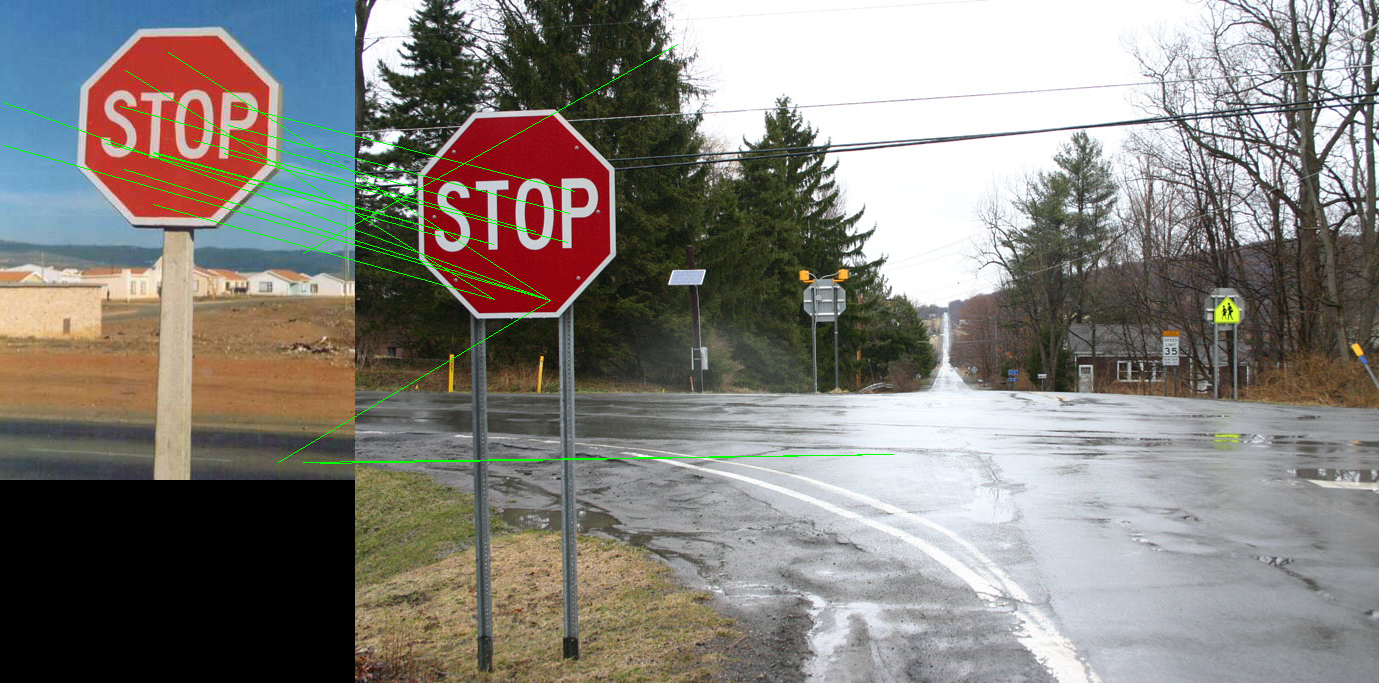

Number of matches(Distance ratio): 33


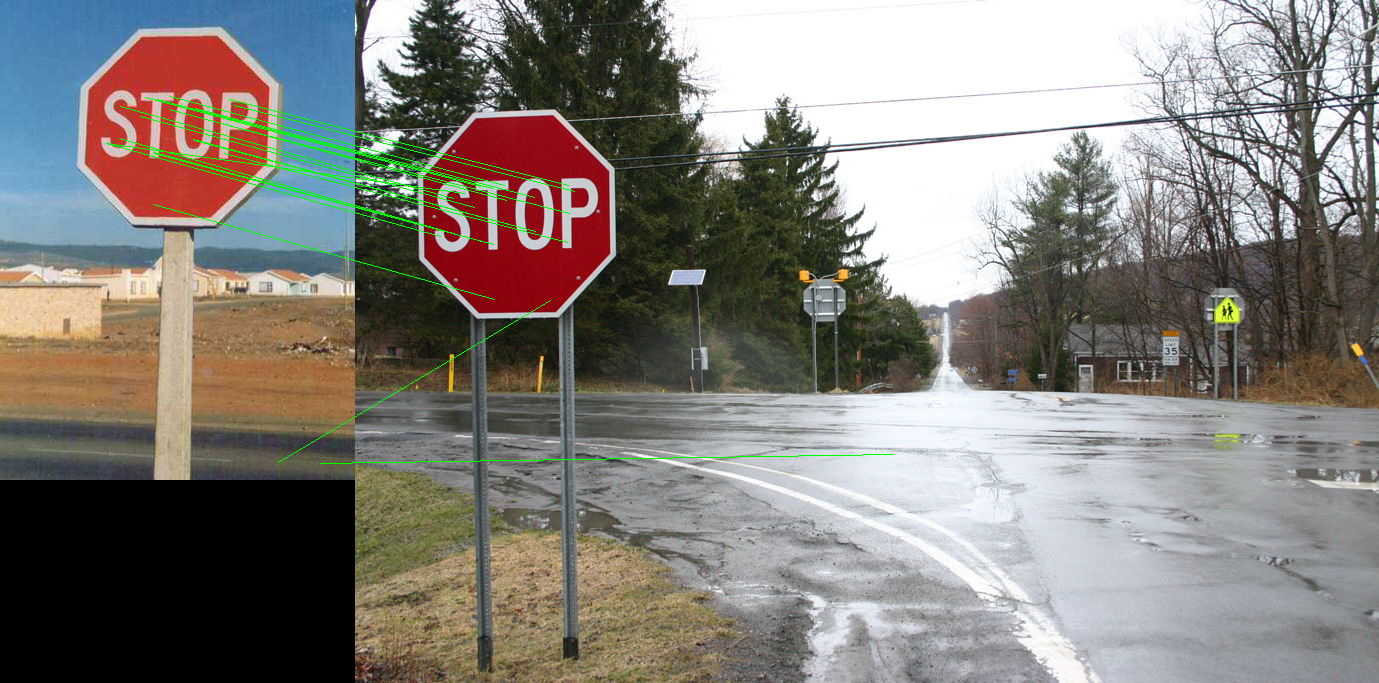

In [10]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')
## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']


## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2

## Display the matched keypoints
nearest_th, dist_ratio_th = [], []
for i in range(Descriptor1.shape[1]):
  ssd = []
  for j in range(Descriptor2.shape[1]):
    sq_distances = (Descriptor1[:,i] - Descriptor2[:,j])**2
    ssd.append(np.sum(sq_distances))
  nearest_1 = np.min(ssd)
  index_1 = np.argmin(ssd)
  ssd[index_1]= np.max(ssd)
  nearest_2 = np.min(ssd)
  index_2 = np.argmin(ssd)

  if nearest_1 < 3500:
    nearest_th.append([i, index_1])

  ratio_dist = nearest_1 / nearest_2
  if ratio_dist < 0.8:
    dist_ratio_th.append([i, index_1])

#Visualizing the results
final_img = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1],3), dtype=np.float32)
final_img[0:480,0:355] = img1
final_img[:,355:1379] = img2
final_img_2 = final_img.copy()

print('Number of matches(Nearest neighbour distances):',len(nearest_th))
for i in range(len(nearest_th)):
    cv2.line(final_img, (int(Frame1[0,nearest_th[i][0]]), int(Frame1[1,nearest_th[i][0]])), (int(Frame2[0,nearest_th[i][1]])+355, int(Frame2[1,nearest_th[i][1]])), (0,255,0), 1)
cv2_imshow(final_img)

print('Number of matches(Distance ratio):',len(dist_ratio_th))
for i in range(len(dist_ratio_th)):
    cv2.line(final_img_2, (int(Frame1[0,dist_ratio_th[i][0]]), int(Frame1[1,dist_ratio_th[i][0]])), (int(Frame2[0,dist_ratio_th[i][1]])+355, int(Frame2[1,dist_ratio_th[i][1]])), (0,255,0), 1)
cv2_imshow(final_img_2)

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Answers:**  
1. Nearest Neighbor Distances:  the sum of squared distances are calculated for each descriptor in image1 with each descriptor in image2.

2. Distance Ratio:   ratio of the minimum and the second minimum nearest neighbour are calculated.

**Difference:** In thresholding the SSD for the nearest neighbour distance method, the threshold that is to be set is difficult which can be inaccurate as a correct match can have a larger distance than an incorrect match. Therefore, distance ratio is better strategy which reduces 90% of the false matches, as a low distance ratio implies a good match while a high distance ratio can be an ambigous match.